In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [8]:
df = pd.read_csv("Price_Rev_Hotel_Clean.csv", sep = '\t')

C:\Users\rawin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.dtypes

Unnamed: 0                          int64
hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                      

In [0]:
df = df.drop(['Unnamed: 0','YR_MNTH_ind'], axis=1)

Using all the variables in the model gives a high accuracy. But in the interest of generalizing the model to work for customers about whom we might not have as much information, we will manually remove some columns.

Number of guests is removed since its a column that was added based on other columns in the dataset. 
Previous cancellations and bookings not cancelled were removed since the hotels will not have this information for first time customers.
Reservation status is a feature that captures the last known status of the reservation. Since this can give a clear indication of whether the booking is already cancelled or not, it was removed.

In [0]:
numerical_variables = df.select_dtypes(include=['int64', 'float64']).drop(['is_canceled','number_of_guests',
                                                                           'previous_cancellations','previous_bookings_not_canceled'], axis=1).columns
categorical_variables = df.select_dtypes(include=['object']).drop(['reservation_status'], axis=1).columns

In [0]:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('one_hot', OneHotEncoder(handle_unknown='ignore'))])
    
preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_variables),
            ('cat', categorical_transformer, categorical_variables)])

In [0]:
X=df.drop(['is_canceled','number_of_guests','reservation_status','previous_cancellations','previous_bookings_not_canceled'],axis=1)
Y=df['is_canceled']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

### Logistic Regression Model:

In [0]:
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

lr_model.fit(X_train, Y_train)

lr_y_pred = lr_model.predict(X_test)
lr_y_score = lr_model.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
print('Accuracy in test data: ', accuracy_score(Y_test,lr_y_pred))
print('F1 Score:',f1_score(Y_test,lr_y_pred))
print('AUROC:',roc_auc_score(Y_test, lr_y_score[:,1]))

Accuracy in test data:  0.8596314626848978
F1 Score: 0.7949346405228758
AUROC: 0.9264949385701107


In [0]:
print(classification_report(Y_test, lr_y_pred, target_names=['not cancelled','cancelled']))

               precision    recall  f1-score   support

not cancelled       0.85      0.93      0.89     22372
    cancelled       0.86      0.73      0.79     13391

     accuracy                           0.85     35763
    macro avg       0.86      0.83      0.84     35763
 weighted avg       0.86      0.85      0.85     35763



### Random Forest Model:

In [0]:
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])

rf_model.fit(X_train, Y_train)

rf_y_pred = rf_model.predict(X_test)
rf_y_score = rf_model.predict_proba(X_test)

In [0]:
print('Accuracy in test data: ',accuracy_score(Y_test,rf_y_pred))
print('F1 Score:',f1_score(Y_test,rf_y_pred))
print('AUROC:',roc_auc_score(Y_test, rf_y_score[:,1]))

Accuracy in test data:  0.9055727987025697
F1 Score: 0.8652810467945905
AUROC: 0.9673216880483774


In [0]:
print(classification_report(Y_test, rf_y_pred, target_names=['not cancelled','cancelled']))

               precision    recall  f1-score   support

not cancelled       0.89      0.96      0.93     22372
    cancelled       0.93      0.81      0.87     13391

     accuracy                           0.91     35763
    macro avg       0.91      0.89      0.90     35763
 weighted avg       0.91      0.91      0.90     35763



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

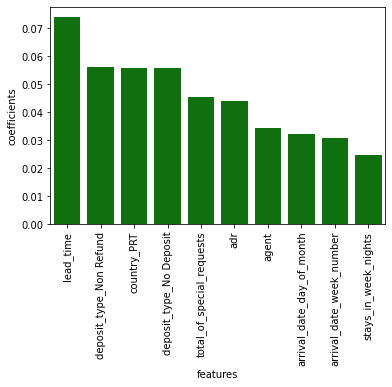

In [0]:
coefficients  = pd.DataFrame(rf_model.named_steps["classifier"].feature_importances_)
column_df1     = pd.DataFrame(rf_model.named_steps['preprocessor'].transformers_[1][1].named_steps['one_hot'].get_feature_names(categorical_variables))
column_df2     = pd.DataFrame(list(numerical_variables))

frames = [column_df2,column_df1]
column_df = pd.concat(frames).reset_index(drop=True)

coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
coef_sumry.columns = ["coefficients","features"]
coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False).iloc[:10]

ax = sns.barplot(x="features", y="coefficients", data=coef_sumry, color="g")
plt.xlabel('features')
plt.ylabel('coefficients')
plt.xticks(rotation=90)

The below is Random forest using grid search and cross validation to identify the best compbination of parameters. It takes a while to run (2 minutes ish - in jupyter, about 15 min here) and turns out worse then the default settings. We could play around with the values in the grid to get better, but for now default RF is the way to go.




In [0]:
# RF With Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'classifier__max_depth': [40, 60],
    'classifier__min_samples_leaf': [4, 7],
    'classifier__min_samples_split': [50, 75],
    'classifier__n_estimators': [60, 80, 100]
}

rf_search = GridSearchCV(rf_model, param_grid, n_jobs=-1, cv=5, verbose = 3)
rf_search.fit(X_train, Y_train)
rf_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 19.0min finished


{'classifier__max_depth': 60,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 60}

In [0]:
rf_model_gs = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(max_depth=60,n_estimators=60,min_samples_leaf=4,min_samples_split=50))])

rf_model_gs.fit(X_train, Y_train)

rf_y_pred_gs = rf_model_gs.predict(X_test)
rf_y_score_gs = rf_model_gs.predict_proba(X_test)

print('Accuracy in test data: ',accuracy_score(Y_test,rf_y_pred_gs))
print('F1 Score:',f1_score(Y_test,rf_y_pred_gs))
print('AUROC:',roc_auc_score(Y_test, rf_y_score_gs[:,1]))

Accuracy in test data:  0.850907362357744
F1 Score: 0.7673647469458987
AUROC: 0.9390089126151067


## Gradient Boosting Classifier

I wanted to get a GB model working well before switching to XGB. As of right now it's not beating the default RF either. I can keep playing with the values in the grid to see if I can beat it, but I don't know if it's worth it at this point.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
# GB without paramter tuning
gb_model=Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingClassifier())])
gb_model.fit(X_train, Y_train)

gb_y_pred = gb_model.predict(X_test)
gb_y_score = gb_model.predict_proba(X_test)

print('Accuracy in test data: ',accuracy_score(Y_test,gb_y_pred))
print('F1 Score:',f1_score(Y_test,gb_y_pred))
print('AUROC:',roc_auc_score(Y_test, gb_y_score[:,1]))

Accuracy in test data:  0.8447557531526997
F1 Score: 0.7793147309007075
AUROC: 0.9228515281945545


In [0]:
# Tune  Parameters
param_grid = {
    'classifier__max_depth': [12, 15],
    'classifier__max_features': ["sqrt"],
    'classifier__min_samples_leaf': [7 , 15, 25],
    'classifier__min_samples_split': [50 , 100],
    'classifier__n_estimators': [70, 90]
}

gb_search = GridSearchCV(gb_model, param_grid, n_jobs=-1, cv=5, verbose = 3)
gb_search.fit(X_train, Y_train)
gb_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 11.6min finished


{'classifier__max_depth': 15,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 7,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 90}

In [0]:
gb_model_gs = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GradientBoostingClassifier(max_depth=15,min_samples_leaf=7,min_samples_split=50,n_estimators=90,max_features='sqrt'))])

gb_model_gs.fit(X_train, Y_train)

gb_y_pred_gs = gb_model_gs.predict(X_test)
gb_y_score_gs = gb_model_gs.predict_proba(X_test)

print('Accuracy in test data: ',accuracy_score(Y_test,gb_y_pred_gs))
print('F1 Score:',f1_score(Y_test,gb_y_pred_gs))
print('AUROC:',roc_auc_score(Y_test, gb_y_score_gs[:,1]))

Accuracy in test data:  0.8773033582193888
F1 Score: 0.8259558940187213
AUROC: 0.9494253307422333


# XG Boost

In [0]:
import xgboost as xgb #xgb.XGBClassifier
xgb_model=Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb.XGBClassifier())])
xgb_model.fit(X_train, Y_train)

xgb_y_pred = xgb_model.predict(X_test)
xgb_y_score = xgb_model.predict_proba(X_test)

print('Accuracy in test data: ',accuracy_score(Y_test,xgb_y_pred))
print('F1 Score:',f1_score(Y_test,xgb_y_pred))
print('AUROC:',roc_auc_score(Y_test, xgb_y_score[:,1]))

Accuracy in test data:  0.8433017364315074
F1 Score: 0.7753187394755834
AUROC: 0.9218032543399627


In [0]:
# Tune  Parameters
param_grid = {
        'classifier__min_child_weight': [1, 5, 10],
        'classifier__gamma': [0.5, 1, 1.5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 5]
        }

xgb_search = GridSearchCV(xgb_model, param_grid, n_jobs=-1, cv=3, verbose = 3)
xgb_search.fit(X_train, Y_train)
xgb_search.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed: 69.6min finished


{'classifier__colsample_bytree': 0.6,
 'classifier__gamma': 0.5,
 'classifier__max_depth': 5,
 'classifier__min_child_weight': 1,
 'classifier__subsample': 0.6}

In [0]:
xgb_model_gs = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(min_child_weight=1,gamma=0.5,subsample=0.6,colsample_bytree=0.6,max_depth=5))])

xgb_model_gs.fit(X_train, Y_train)

xgb_y_pred_gs = xgb_model_gs.predict(X_test)
xgb_y_score_gs = xgb_model_gs.predict_proba(X_test)

print('Accuracy in test data: ',accuracy_score(Y_test,xgb_y_pred_gs))
print('F1 Score:',f1_score(Y_test,xgb_y_pred_gs))
print('AUROC:',roc_auc_score(Y_test, xgb_y_score_gs[:,1]))

Accuracy in test data:  0.8585968738640495
F1 Score: 0.8005206895191511
AUROC: 0.9367294559380402
